In [1]:
import datetime
import operator
import os
import os.path

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

from io import StringIO
from matplotlib import rcParams
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA


# Don't cut xlabel when saving .fig
rcParams.update({'figure.autolayout': True})

# Convert datetime for matplotlib
register_matplotlib_converters()

In [12]:
# Find number of channels in house_1
def load_REDD_house(i_house):
    """Loads data from a REDD dataset house. The 'low_freq' directory must be in the root of the project.
    
    Args:
        i_house (int): index of the house.
    
    Returns:
        (list, DataFrame): tuple of a list of each channel consumption data,
        and a DataFrame of the labels identifying the appliance of each channel.
        of the query as [index, date, daily forecasted consumption].
    """
    path = 'low_freq/house_{}/'.format(i_house)
    num_channels = len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))]) - 1

    # Load consumption data
    channels = []
    for i in range(num_channels):
        ch = pd.read_csv(path + 'channel_{}.dat'.format(i + 1), delimiter=' ', names=['t', 'pot'])
        ch.t = pd.to_datetime(ch.t, unit='s')
        channels.append(ch)

    # Load labels
    labels = pd.read_csv(path + 'labels.dat', delimiter=' ', names=['i', 'name'])
    
    return channels, labels

channels, labels = load_REDD_house(1)

pandas.core.frame.DataFrame

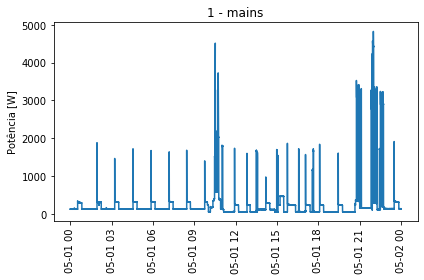

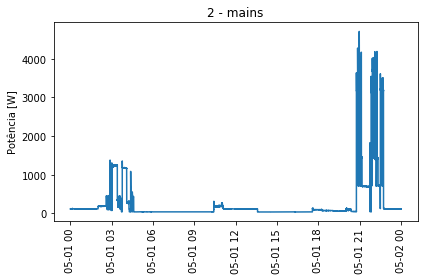

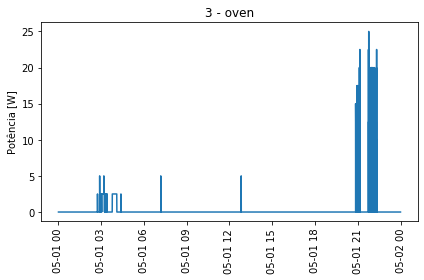

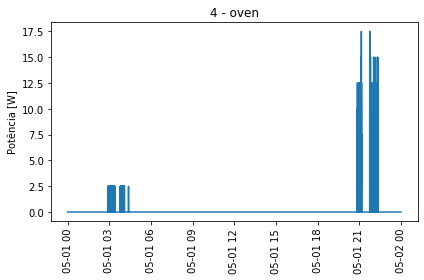

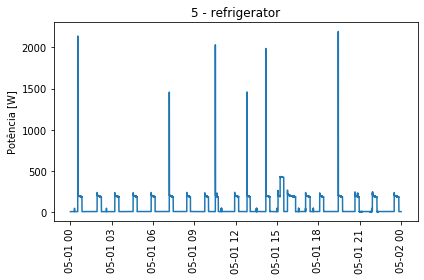

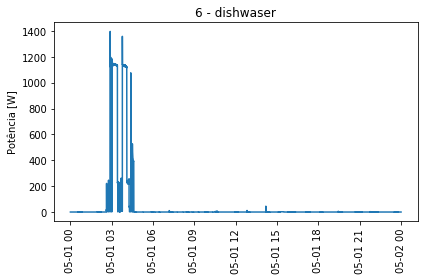

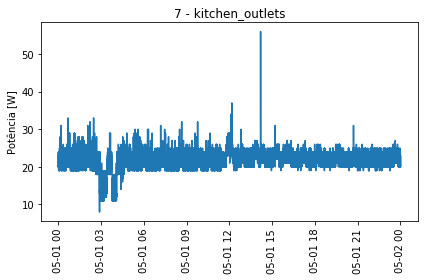

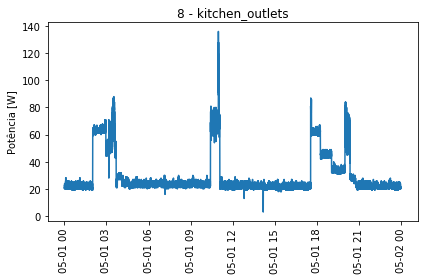

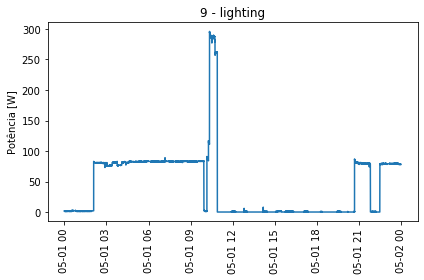

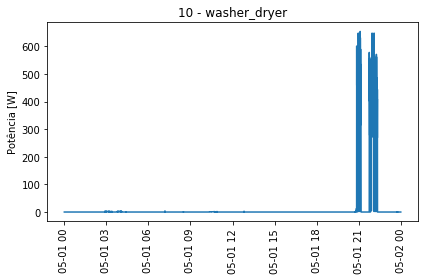

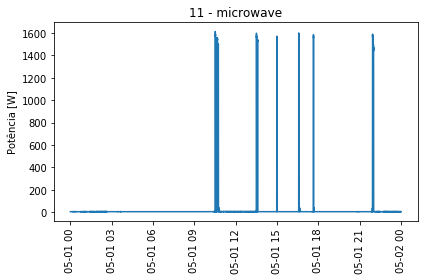

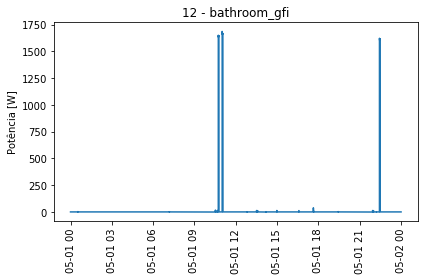

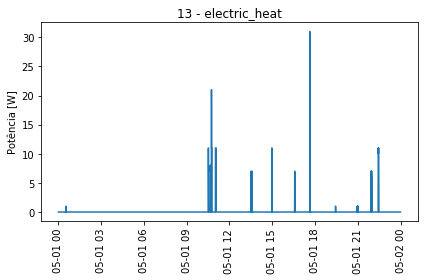

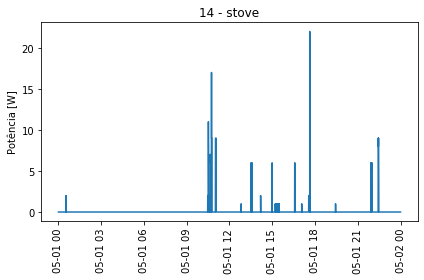

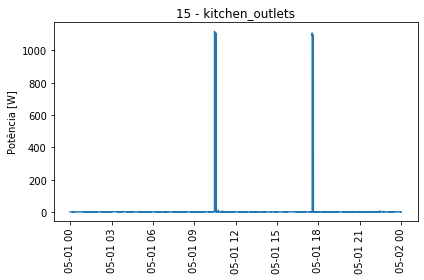

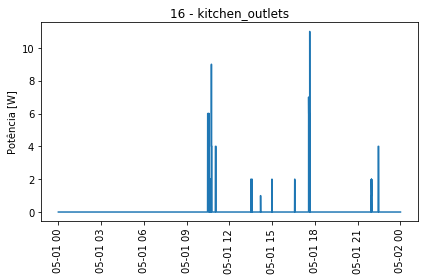

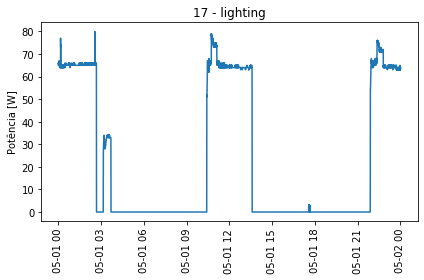

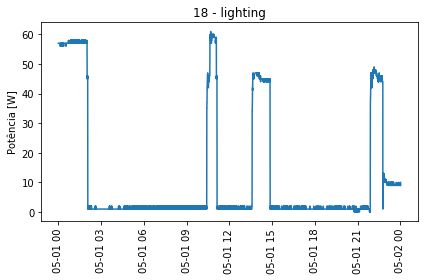

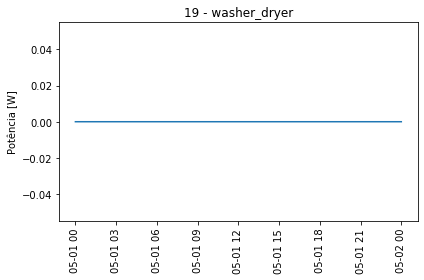

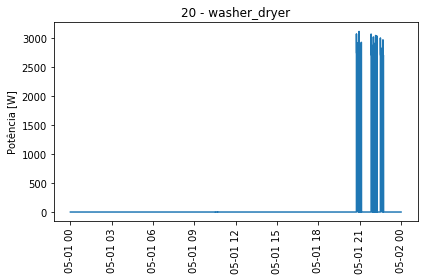

In [3]:
def qry_pot_channel(start, end, i_channel):
    """Runs a query for the potency consumption in a channel in the specified period.
    
    Args:
        start (str): start of the period as "YYYY-MM-DD hh:mm:ss".
        end (str): end of the period as "YYYY-MM-DD hh:mm:ss"
        i_channel(int): index of the channel.
    
    Returns:
        str: csv of the query as [index, time, consumption].
    """
    if i_channel < 1 or i_channel > len(channels):
        raise Exception('Channel number should be 1-{}. The value was {}'.format(len(labels), i_channel))
    
    # Select the desired period from channel
    ch = channels[i_channel - 1]
    mask = (ch.t >= start) & (ch.t < end)
    ch_period = ch.loc[mask]
    
    # Return query as csv string
    return ch_period.to_csv()


# Plot data from day 2011-05-01
for i in range(len(channels)):
    query = qry_pot_channel('2011-05-01', '2011-05-02 00:00:05', i + 1)
    
    # Convert query string to pandas.DataFrame
    ch = pd.read_csv(StringIO(query), delimiter=',', header=0, usecols=[1, 2])
    ch.t = pd.to_datetime(ch.t)
    
    # Plot query results
    plt.plot(ch.t, ch.pot)
    plt.title(str(i + 1) + " - " + labels.iloc[i]['name'])
    plt.ylabel('Potência [W]')
    plt.xticks(rotation=90)
    plt.savefig('plot/day-05-01/channel_{}.png'.format(i + 1))
    plt.show()

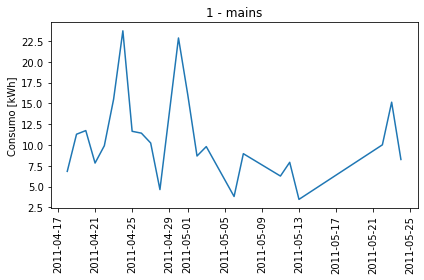

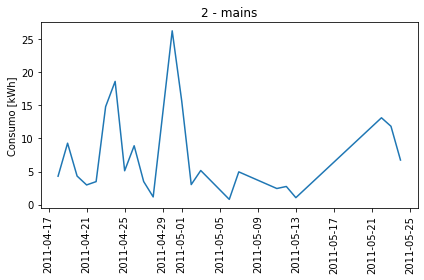

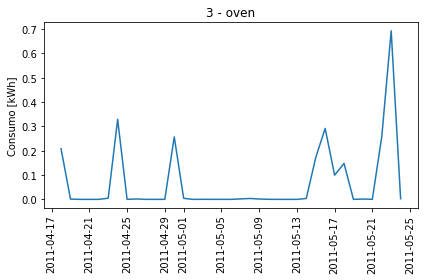

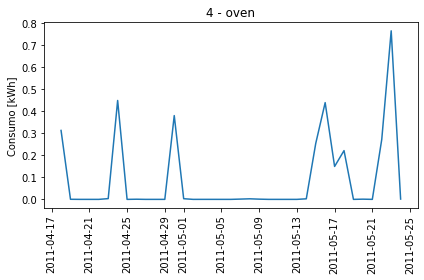

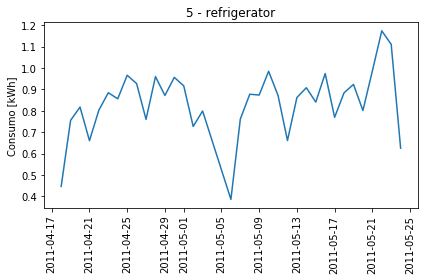

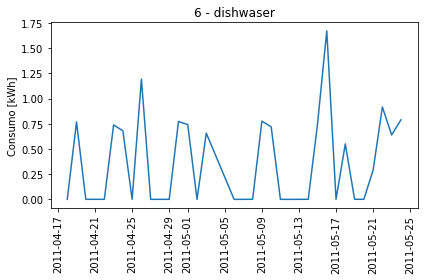

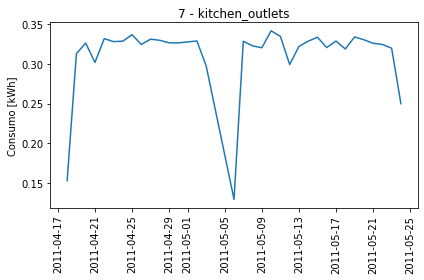

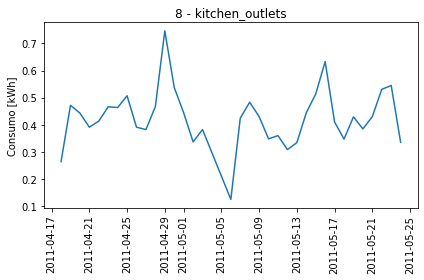

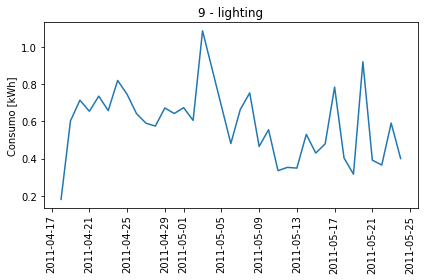

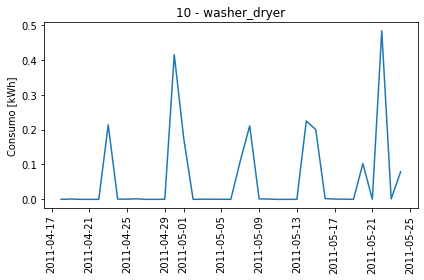

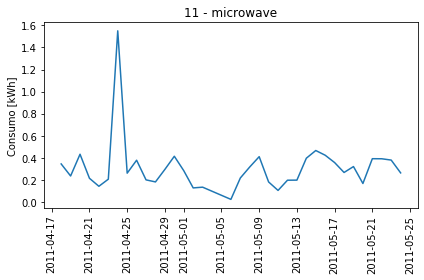

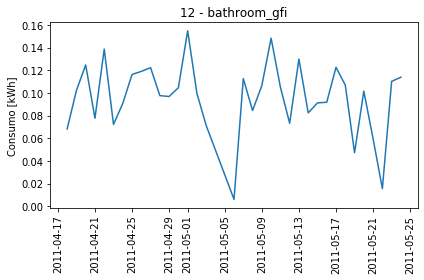

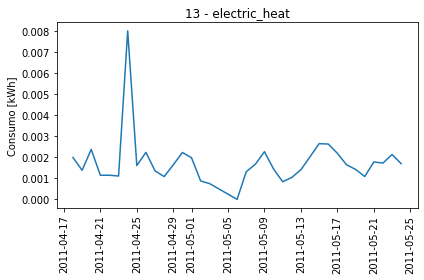

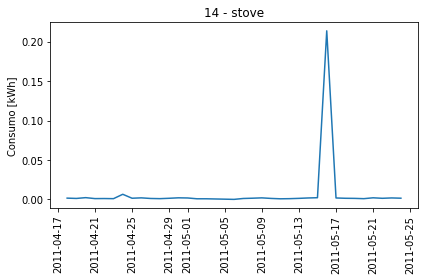

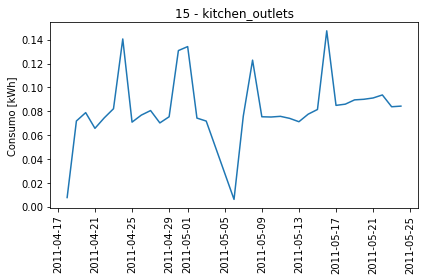

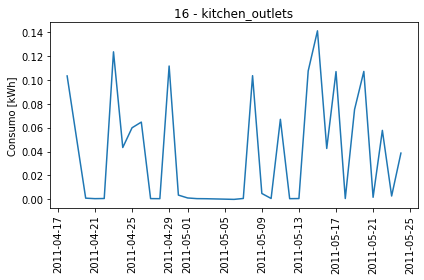

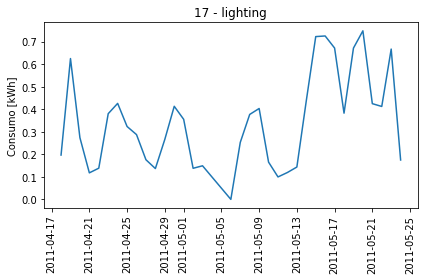

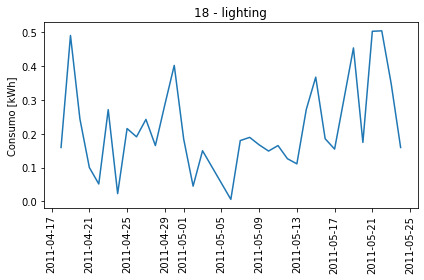

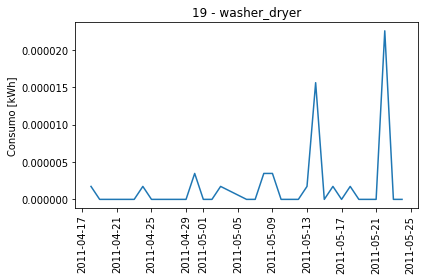

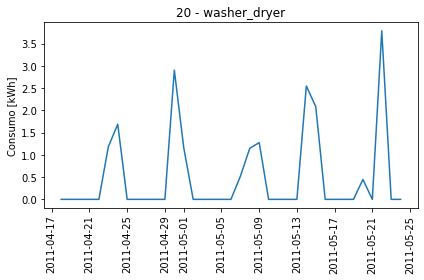

In [4]:
def qry_daily_cons_channel(start, end, i_channel):
    """Runs a query for the daily consumption in a channel in the specified period.
    
    Args:
        start (str): start of the period as "YYYY-MM-DD hh:mm:ss".
        end (str): end of the period as "YYYY-MM-DD hh:mm:ss".
        i_channel (int): index of the channel.
    
    Returns:
        str: csv of the query as [index, date, daily consumption].
    """
    if i_channel < 1 or i_channel > len(channels):
        raise Exception('Channel number should be 1-{}. The value was {}'.format(len(labels), i_channel))
    
    # Select the desired period from channel
    ch = channels[i_channel - 1]
    mask = (ch.t >= start) & (ch.t < end)
    ch_period = ch.loc[mask]
    
    # Aggregate consumption by day
    cons = ch_period.copy()
    cons = cons.set_index('t')
    cons = cons.groupby(pd.Grouper(freq='D')).transform(np.cumsum).resample('D').ohlc()
    cons = cons.reset_index()
    cons = pd.concat([cons.t, cons.pot.high], axis=1)
    cons.columns = ['t', 'energy']
    
    # Remove days without consumption data
    cons = cons[~cons.energy.isna()]
    
    # Convert to kWh. Period between measures is 2.5 s
    cons.energy *= 2.5 / (1e3 * 3600)
    
    # Return query as csv string
    return cons.to_csv()


# Plot daily consumption for each channel for all period available
day_cons = []
for i in range(len(channels)):
    query = qry_daily_cons_channel('2011-04-17', '2011-05-25 00:00:05', i + 1)
    
    cons = pd.read_csv(StringIO(query), delimiter=',', header=0, usecols=[1, 2])
    cons.t = pd.to_datetime(cons.t)
    
    day_cons.append(cons)
    plt.plot(cons.t, cons.energy)
    plt.title(str(i + 1) + " - " + labels.iloc[i]['name'])
    plt.ylabel('Consumo [kWh]')
    plt.xticks(rotation=90)
    plt.savefig('plot/daily/channel_{}.png'.format(i + 1))
    plt.show()

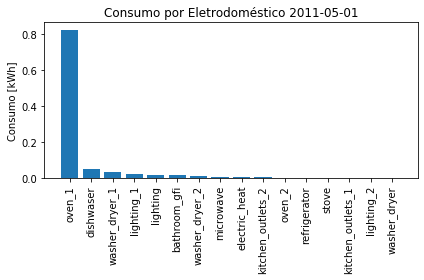

In [5]:
import csv
from io import StringIO

# Plot total consumption by each channel on day 2011-05-01
def qry_total_cons_all(start, end, percentage=False):
    """Runs a query for the total consumption in each channel in the specified period.
    
    Args:
        start (str): start of the period as "YYYY-MM-DD hh:mm:ss".
        end (str): end of the period as "YYYY-MM-DD hh:mm:ss".
        percentage (bool): if true, return percentage of total consumption of each channel.
    
    Returns:
        str: csv of the query as [label; total consumption].
    """
    total_cons = {}
    for i in range(0, len(channels)):
        # Select the desired period from channel
        ch = channels[i - 1]
        mask = (ch.t >= start) & (ch.t < end)
        ch_period = ch.loc[mask]

        # Aggregate consumption
        cons = ch_period['pot'].sum()

        # Convert to kWh. Period between measures is 2.5 s
        cons *= 2.5 / (1e3 * 3600)
        
        # Add total consumption of channel i to day_cons hash map
        appliance_name = labels.iloc[i]['name']
        if appliance_name != 'mains':
            if appliance_name not in total_cons: 
                total_cons[appliance_name] = cons
            else:
                total_cons[appliance_name + '_1'] = total_cons.pop(appliance_name)
                total_cons[appliance_name + '_2'] = cons
    
    if percentage == True:
        sum = 0
        for key, value in total_cons.items():
            sum += value
        for key, value in total_cons.items():
            total_cons[key] /= sum
    
    sorted_cons = sorted(total_cons.items(), key=operator.itemgetter(1), reverse=True)
    
    result = ','.join([item[0] for item in sorted_cons]) + '\n'
    result += ','.join([str(item[1]) for item in sorted_cons])
    return result


query = qry_total_cons_all('2011-05-01', '2011-05-02', percentage=True)

f = StringIO(query)
qry_reader = csv.reader(f, delimiter=',')
sorted_cons = []
for row in qry_reader:
    sorted_cons.append(row)

for i in range(len(sorted_cons[1])):
    sorted_cons[1][i] = float(sorted_cons[1][i])

plt.title('Consumo por Eletrodoméstico 2011-05-01')
plt.bar(sorted_cons[0], sorted_cons[1])
plt.ylabel('Consumo [kWh]')
plt.xticks(rotation=90)
plt.savefig('plot/day-05-01/by_channel.png')

In [6]:
# ARMA and ARIMA forecast
days_predicted = 7
i_channel = 5

query = qry_daily_cons_channel('2011-04-17', '2011-05-25', i_channel)
cons = pd.read_csv(StringIO(query), delimiter=',', header=0, usecols=[1, 2])
cons.t = pd.to_datetime(cons.t)

test = cons.iloc[:15, :]
test.t = test.t.dt.date

date = test.t.iloc[-1]
predict_dates = []
for i in range(days_predicted + 1):
    predict_dates.append(date)
    date += datetime.timedelta(days=1)

/home/tiago/anaconda3/envs/my_env/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


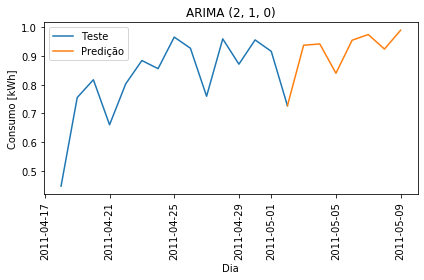

In [7]:
def qry_ARIMA(days_predicted, pdq):
    """Runs a query for the forecast consumption using an ARIMA model.
    
    Args:
        days_predicted (int): number of days to forecast.
        pdq (iterable): order of the model parameters.
    
    Returns:
        str: csv of the query as [index, date, daily forecasted consumption].
    """
    model = ARIMA(test.energy, pdq)
    model_fit = model.fit(disp=0)
    predicted = model_fit.forecast(days_predicted)
    
    # Add daily consumption of current day
    predict_cons = np.insert(predicted[0], 0, test.energy.iloc[-1])
    
    # Convert to pandas.DataFrame
    result = pd.DataFrame(np.transpose([predict_dates, predict_cons]))
    result.columns = ['t', 'energy']
    
    return result.to_csv()


# Plot forecast for 7 days consumption in channel 5 with ARIMA(2, 1, 0)
query = qry_ARIMA(7, (2, 1, 0))
predict = pd.read_csv(StringIO(query), delimiter=',', header=0, usecols=[1, 2])
predict.t = pd.to_datetime(predict.t)

plt.title('ARIMA (2, 1, 0)')
plt.plot(test.t.values, test.energy.values)
plt.plot(predict.t, predict.energy)
plt.legend(('Teste', 'Predição'))
plt.ylabel('Consumo [kWh]')
plt.xlabel('Dia')
plt.xticks(rotation=90)
plt.savefig('plot/ARIMA/arima210.png')

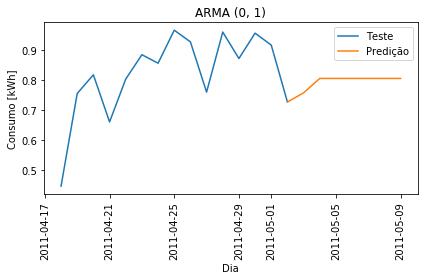

In [8]:
query = qry_ARIMA(7, (0, 0, 1))
predict = pd.read_csv(StringIO(query), delimiter=',', header=0, usecols=[1, 2])
predict.t = pd.to_datetime(predict.t)

plt.title('ARMA (0, 1)')
plt.plot(test.t.values, test.energy.values)
plt.plot(predict.t, predict.energy)
plt.legend(('Teste', 'Predição'))
plt.ylabel('Consumo [kWh]')
plt.xlabel('Dia')
plt.xticks(rotation=90)
plt.savefig('plot/ARIMA/arma01.png')

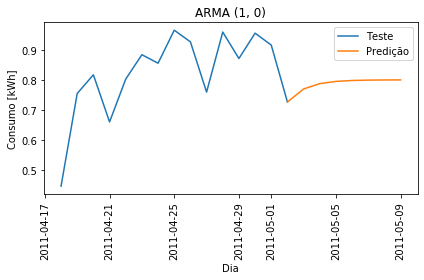

In [9]:
query = qry_ARIMA(7, (1, 0, 0))
predict = pd.read_csv(StringIO(query), delimiter=',', header=0, usecols=[1, 2])
predict.t = pd.to_datetime(predict.t)

plt.title('ARMA (1, 0)')
plt.plot(test.t.values, test.energy.values)
plt.plot(predict.t, predict.energy)
plt.legend(('Teste', 'Predição'))
plt.ylabel('Consumo [kWh]')
plt.xlabel('Dia')
plt.xticks(rotation=90)
plt.savefig('plot/ARIMA/arma10.png')